In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torch_mist.data.multimixture import MultivariateCorrelatedNormalMixture
from torch_mist.utils import train_mi_estimator
import pandas as pd

sns.set_style('whitegrid')
IMG_SIZE=3
n_dim = 5

train_parameters = dict(
    max_epochs=10,
    batch_size= 128,
    return_log=True,
    verbose=True,
    valid_percentage=0,
    lr_annealing=True,
)

# Definition of the distribution
p_XY = MultivariateCorrelatedNormalMixture(n_dim=n_dim)

true_mi = p_XY.mutual_information('x','y')

p_Y_given_X = p_XY.conditional('x')
p_Y = p_XY.marginal('y')

In [2]:
samples = p_XY.sample([100000])



In [63]:
from torch_mist.estimators import nwj, mine, doe, js, flo
from torch_mist.utils.logging import PandasLogger
from torch_mist.utils.logging.agg import compute_mean_std

estimators = {
    # 'DoE': doe(
    #     x_dim=n_dim,
    #     y_dim=n_dim,
    #     hidden_dims=[256, 128],
    #     conditional_transform_name='conditional_spline',
    #     marginal_transform_name='spline'
    # ),
    'MINE': mine(
        x_dim=n_dim,
        y_dim=n_dim,
        hidden_dims=[256, 128],
        neg_samples=32
    )
}



logger = PandasLogger()
for name, estimator in estimators.items():
    logger.log_method(estimator, method_name='log_ratio', agg=compute_mean_std)
    logger.log_method(estimator, method_name='batch_loss', agg=compute_mean_std)


In [64]:
log = train_mi_estimator(
    estimator=estimators['MINE'],
    x=samples['x'],
    y=samples['y'],
    batch_size=128,
    max_epochs=10,
    early_stopping=False,
    logger=logger,
    lr_annealing=False,
    optimizer_params={'lr':5e-4}
)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/704 [00:00<?, ?it/s]

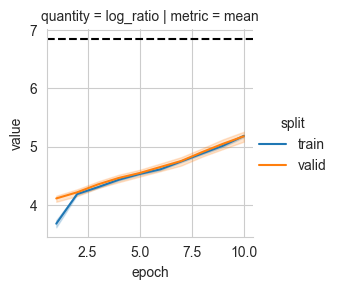

In [65]:
train_log = log[log['split']=='train']
valid_log = log[log['split']=='valid']

log_ratio_log = log[log['quantity']=='log_ratio']

grid = sns.FacetGrid(log, col='metric', hue='split', row='quantity', row_order=['log_ratio'], col_order=['mean'])
grid.map(sns.lineplot, 'epoch', 'value')
grid.add_legend()

# plt.ylim(0,10)
for ax in grid.axes[0]:
    ax.axhline(y=true_mi, ls='--', color='k')


In [66]:
log_ratio_log

,metric,value,quantity,iteration,epoch,split
2,mean,-0.019618,log_ratio,0,1,train
3,std,0.077332,log_ratio,0,1,train
6,mean,0.022485,log_ratio,1,1,train
7,std,0.069918,log_ratio,1,1,train
10,mean,0.060533,log_ratio,2,1,train
...,...,...,...,...,...,...
29735,std,3.055787,log_ratio,7040,10,valid
29736,mean,5.413028,log_ratio,7040,10,valid
29737,std,2.591882,log_ratio,7040,10,valid
29738,mean,2.317966,log_ratio,7040,10,valid


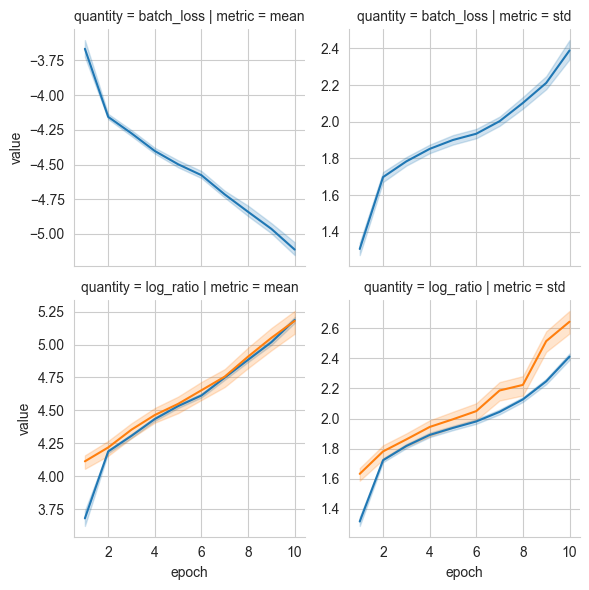

In [67]:
grid = sns.FacetGrid(log, row='quantity', col='metric', hue='split', sharey=False, sharex=True)
grid.map(sns.lineplot, 'epoch', 'value')
# plt.ylim(0,20)

In [44]:
pd_log[pd_log['method']=='log_ratio']['std']

1        0.110689
4        0.110689
6        0.124799
9        0.124799
11       0.122420
           ...   
73481    0.560039
73483    9.469671
73485    4.428857
73487    0.561075
73489    0.594490
Name: std, Length: 29710, dtype: float64

In [28]:
train_log[train_log['split']=='validation']

,I(x;y),loss,epoch,split,iteration,lr
1407,4.4442,NaN,1,validation,1407,NaN
2815,4.479627,NaN,2,validation,2814,NaN
4223,4.398395,NaN,3,validation,4221,NaN
5631,4.367286,NaN,4,validation,5628,NaN
7039,4.550091,NaN,5,validation,7035,NaN
8447,4.393708,NaN,6,validation,8442,NaN
9855,4.559145,NaN,7,validation,9849,NaN
11263,4.490069,NaN,8,validation,11256,NaN
